In [1]:
import requests
import time
from bs4 import BeautifulSoup
import random
import pandas as pd
import re
from IPython.display import display, HTML
import urllib.parse

# Job Scraping

In [2]:
# Title of job in search
title = "Data Scientist"
encoded_job_title = title.replace(" ", "%2B")

# Location
location = "Los Angeles County"
encoded_location = location.replace(" ", "%2B")

# Start position, goes by 10
start_position = 0

# Number of jobs to search
num_jobs = 200



In [3]:
# link for list of job postings on the left on linkedin

all_jobs = []

for start_position in range(0, num_jobs + 1, 10):
    list_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={encoded_job_title}&location={encoded_location}&geoId=&trk=public_jobs_jobs-search-bar_search-submit&start={start_position}"
    response = requests.get(list_url)

    if response.status_code == 200:
        list_data = response.text
        list_soup = BeautifulSoup(list_data, "html.parser")
        more_jobs = list_soup.find_all("li")
        all_jobs.extend(more_jobs)
    else:
        print(f"Failed to retrieve data for start_position={start_position}. Status code: {response.status_code}")
        break  

# Print the total number of jobs found
print(f"Total jobs found: {len(all_jobs)}")




Total jobs found: 210


In [4]:
job_id_list = []

for job in all_jobs:
    # find job_ids
    base_card_div = job.find("div", {"class": "base-card"})
    if base_card_div:  
        job_id = base_card_div.get("data-entity-urn", "")
        if job_id:
            job_id = job_id.split(":")[3]  # Extract ID
            job_id_list.append(job_id)
    else:
        continue
job_id_list = set(job_id_list)
print(len(job_id_list))

197


In [5]:
def clean_description(description):
    if description:
        description = description.text
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', description)
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        
        # Trim leading and trailing spaces
        text = text.strip()

        return text
        


In [75]:
job_list = []

for job_id in job_id_list:
    job_url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"
    job_response = requests.get(job_url)

    # Too many requests will cause error
    if job_response.status_code == 429:
        time.sleep(5)  # Wait for 60 seconds (or more based on LinkedIn's rate limit policy)
        job_response = requests.get(job_url)

    job_soup = BeautifulSoup(job_response.text, "html.parser")

    # Dictionary for each job posting
    job_post = {}
    
    # Clean description used to parse for fields
    raw_description = job_soup.find("div", {"class": "description__text description__text--rich"})
    cleaned_desc = clean_description(raw_description)

    # Check Response
    job_post["response"] = job_response.status_code

    # listing ID
    job_post["id"] = job_id
    
    # time posted
    try:
        job_post["time_posted"] = job_soup.find("span", {"class": "posted-time-ago__text topcard__flavor--metadata"}).text.strip()
    except:
        job_post["time_posted"] = None
    # company name
    try:
        job_post["company_name"] = job_soup.find("a",{"class": "topcard__org-name-link topcard__flavor--black-link"}).text.strip()
    except:
        job_post["company_name"] = None
    
    # company location
    try: 
        job_post["location"] = job_soup.find("span", {"class": "topcard__flavor topcard__flavor--bullet"}).text.strip()
    except:
        job_post["location"] = None
    
    # Role Title
    try:
        job_post["title"] = job_soup.find("h2", {"class":"top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title"}).text.strip()
    except:
        job_post["title"] = None

    # Seniority Level
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        sen_level = level_header.find_next_sibling("span").text.strip()
        job_post["seniority_level"] = sen_level
    except:
        job_post["seniority_level"] = None
        
    # Employment Type (Fulltime, Part-time, internship)
    try:
        level_header = job_soup.find("h3", {"class": "description__job-criteria-subheader"})
        emp_header = level_header.find_next("h3", {"class": "description__job-criteria-subheader"})
        emp_type = emp_header.find_next_sibling("span").text.strip()
        job_post["employment_type"] = emp_type
        
    except:
        job_post["job_type"] = "Job type not specified"
    
    # Years of Experience - Keep as given in description
    try:
        bullet_points = raw_description.find_all(["li", "p"])
        pattern = r'(\d+)\+?\s*years?\s*(?:of experience)?|(\d+)-(\d+)\s*years?\s*(?:of experience)?|(\d+)\s*years?\s*(?:of experience)?'

        matches = re.findall(pattern, cleaned_desc)
        yoe_bullets = []

        for bullet in bullet_points:
            text = bullet.get_text(strip=True)  
            if re.search(pattern, text):  
                yoe_bullets.append(text)

        job_post["yoe"] = yoe_bullets
    except:
        job_post["yoe"] = None

    # Degree Required - format as a list if mulitple degrees

    try:
        pattern = r"(?i)\b(bachelor[’']?s|master[’']?s|ph\.?d|doctorate|b\.?s\.?|m\.?s\.)\b"
        edu = re.findall(pattern, cleaned_desc)
        
        edu = [match.lower().replace("’", "'") for match in edu]
        degree_map = {"bs": "bachelor's", "ms": "master's", "b.s": "bachelor's", "m.s": "master's"}
        formatted_matches = [degree_map.get(match, match) for match in edu]
        degrees = list(set(formatted_matches))
        
        job_post["education"] = degrees
    except:
        job_post["education"] = None

    # Salary
    try:
        salary_div = job_soup.find("div", {"class": "salary compensation__salary"})
        if salary_div:  
            job_post["salary"] = salary_div.text.strip()
        else:
            if raw_description and hasattr(raw_description, 'text'):  # Check if raw_description is not None and has the 'text' attribute
                pattern = r"\$[\d,]+(?:\.\d{2})?\s?-\s?\$[\d,]+(?:\.\d{2})?"
                salary_range = re.findall(pattern, raw_description.text)
                job_post["salary"] = " ".join(salary_range) if salary_range else None
            else:
                job_post["salary"] = None

    except AttributeError as e:
        job_post["salary"] = None

    except:
        job_post["salary"] = None

    # Programming Languages (Python, R, SQL, Java, Scala)
    languages = ['python', 'r', 'sql', 'java', 'scala', 'c++', 'julia', 'matlab', 'dax', 'vba', 'mdx', 'javascript', 'typescript', 'bash', 'shell']

    try:
        pattern = r'\b(?:' + '|'.join(re.escape(lang) for lang in languages) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["programming_languages"] = None
        else:
            job_post["programming_languages"] = matches

    
    except:
        job_post["programming_languages"] = None


    # ML Skills (TensorFlow, PyTorch, Scikit-learn, Keras)
    ml_ai_skills = ['tensorflow', 'pytorch', 'scikit-learn', 'keras', 'xgboost', 'lightgbm', 'catboost', 'fastai', 'mlflow', 'onnx', 'apache mxnet', 
                'hugging face transformers', 'nltk', 'spacy', 'gensim', 'faiss', 'sentence-transformers', 'h2o.ai', 'deepchem', 
                'supervised learning', 'unsupervised learning', 'reinforcement learning', 'graph neural networks', 'computer vision', 
                'nlp', 'bayesian networks', 'logistic regression', 'linear regression', 'decision trees', 'random forest', 'gradient boosting', 
                'support vector machines', 'k-means clustering', 'hierarchical clustering', 'gaussian mixture models', 'hidden markov models', 
                'principal component analysis', 'singular value decomposition', 'time-series forecasting', 'anomaly detection', 'jax', 'genai', 'generativeai']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in ml_ai_skills) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["ml_skills"] = None
        else:
            job_post["ml_skills"] = matches

    
    except:
        job_post["ml_skills"] = None

    # Data Processing & Databases (ETL, Pandas, Spark, Hadoop, Snowflake)
    data_processing_databases = ['etl', 'pandas', 'spark', 'hadoop', 'snowflake', 'airflow', 'dbt', 'kafka', 'redshift', 'bigquery', 'presto', 
                             'trino', 'hive', 'pig', 'databricks', 'delta lake', 'iceberg', 'hudi', 'cassandra', 'mongodb', 'couchdb', 
                             'neo4j', 'arangodb', 'firebase', 'postgresql', 'mysql', 'mariadb', 'sqlite', 'oracle', 'sql server', 
                             'teradata', 'vertica', 'clickhouse', 'greenplum', 'impala', 'exasol', 'druid', 'tidb', 'scyllaDB', 'rockset', 
                             'elasticsearch', 'splunk', 'opensearch', 'flink', 'beam', 'storm', 'dask', 'modin', 'ray[data]', 
                             'polars', 'duckdb', 'voltdb', 'timestream', 'timescaledb', 'influxdb', 'prometheus', 'graphdb', 
                             'yugabyte', 'foundationdb', 'faunadb', 'cosmos db', 'dynamodb']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in data_processing_databases) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["data_processing_db"] = None
        else:
            job_post["data_processing_db"] = matches

    
    except:
        job_post["data_processing_db"] = None


    # Cloud Platforms (AWS, GCP, Azure, OCI)
    cloud_devops_platforms = ['aws', 'gcp', 'azure', 'oci', 'databricks', 'kubernetes', 'docker', 'terraform', 'cloudformation', 'ansible', 
                          'lambda', 'cloud run', 'sagemaker', 'vertex ai', 'azure ml', 'redshift spectrum', 'biglake', 'synapse', 
                          'athena', 'lake formation', 'snowpark', 'gitlab ci/cd', 'github actions', 'jenkins', 'circleci', 'argo workflows', 
                          'kubeflow', 'mlflow', 'airflow', 'dagster', 'prefect', 'kedro', 'bentoml', 'seldon', 'ray[serve]']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in cloud_devops_platforms) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["cloud"] = None
        else:
            job_post["cloud"] = matches

    
    except:
        job_post["cloud"] = None

    # Visualization Tools (Tableau, Power BI, D3.js)
    visualization_tools = ['tableau', 'power bi', 'd3.js', 'looker', 'superset', 'metabase', 'plotly', 'matplotlib', 'seaborn', 'ggplot2', 
                       'altair', 'vega', 'dash', 'streamlit', 'shiny', 'holoviews', 'bokeh', 'oac']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in visualization_tools) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["visualization"] = None
        else:
            job_post["visualization"] = matches

    
    except:
        job_post["data_processing_db"] = None

    # Big Data Tools (Airflow, Kafka, Kubernetes, Golang)
    big_data_tools = ['airflow', 'kafka', 'kubernetes', 'flink', 'storm', 'beam', 'pulsar', 'druid', 'clickhouse', 'redpanda', 'spark streaming', 'terraform']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in big_data_tools) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["big_data"] = None
        else:
            job_post["big_data"] = matches

    
    except:
        job_post["big_data"] = None

    # product skills
    product_skills = ['a/b testing', 'a/b', 'experimentation', 'causal inference', 'growth analytics', 'product analytics', 
                  'feature engineering', 'model deployment', 'mlops', 'explainability', 'ai ethics', 'privacy-preserving ml']

    try:
        
        pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in product_skills) + r')\b'
        matches = re.findall(pattern, cleaned_desc)
        matches = list(set(matches))
        if len(matches) == 0:
            job_post["product_skills"] = None
        else:
            job_post["product_skills"] = matches

    
    except:
        job_post["product_skills"] = None

    # Description
    try:
        job_post["description"] = cleaned_desc
        
    except:
        job_post["description"] = None
    

    job_list.append(job_post)

In [76]:
jobs_df = pd.DataFrame(job_list)
jobs_df


,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4149971204,2 weeks ago,Booz Allen Hamilton,"El Segundo, CA",Space Data Scientist,Not Applicable,Full-time,[3+ years of experience with Data Science to i...,"[bachelors, masters]","$75,600.00/yr - $172,000.00/yr","[python, vba, r, sql]",None,None,None,"[tableau, power bi]",None,None,job number r0214628space data scientist the op...,NaN
1,200,4162691844,1 day ago,tvScientific,"Los Angeles, CA",Senior Machine Learning Engineer,Mid-Senior level,Full-time,[],[],"$180,000.00/yr - $210,000.00/yr","[python, scala]",[reinforcement learning],"[beam, spark]",[aws],None,[beam],[experimentation],job title senior machine learning engineer loc...,NaN
2,200,4138003303,1 month ago,Atticus,"Los Angeles, CA",Data Scientist,Entry level,Full-time,[You have 4+ years of relevant industry experi...,[],"$150,000.00/yr - $180,000.00/yr","[python, sql]",None,None,None,None,None,"[experimentation, causal inference]",about atticus at any given time 16 million ame...,NaN
3,200,4002283191,2 weeks ago,Amazon Web Services (AWS),"Pasadena, CA","Applied Scientist, AWS AI Foundational Researc...",Not Applicable,Full-time,"[PhD, or Master's degree and 4+ years of CS, C...",[masters],"$136,000.00/yr - $223,400.00/yr","[java, python]",None,None,[aws],None,None,None,description amazon is looking for world class ...,NaN
4,200,4186285952,None,Axiom Global Technologies,"Glendale, CA",Senior Data Scientist,Mid-Senior level,Contract,[10+ years of experience in data engineering o...,[],None,"[python, r, sql]",None,"[etl, spark, databricks]","[gcp, databricks]",None,None,None,qualifications10 years of experience in data e...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,200,4167325145,3 weeks ago,ProRata.ai,"Pasadena, CA",Principal AI Researcher,Mid-Senior level,Full-time,[],[],"$230,000.00/yr - $300,000.00/yr",[python],[graph neural networks],[pandas],None,None,None,[feature engineering],generative ai is transforming the way we inter...,NaN
193,200,4181561717,2 days ago,Banking Funding Company,"El Segundo, CA",Senior Python developer,Mid-Senior level,Full-time,[],[],None,"[python, sql]",None,"[neo4j, snowflake, splunk]","[kubernetes, aws, docker, azure, gcp]","[superset, power bi]",[kubernetes],None,senior python developer with snowflake and fla...,NaN
194,200,4182897226,3 days ago,AMH,"Calabasas, CA","Senior Manager, Data Science",Mid-Senior level,Full-time,[],[masters],"$124,486 - $161,860","[python, r, sql]",[xgboost],"[pandas, spark, databricks]","[azure, databricks]","[tableau, power bi]",None,None,job description since 2012 weve grown to becom...,NaN
195,200,4058085294,5 months ago,PRIMUS Global Technologies Pvt Ltd,"Los Angeles, CA",Clinical Data Scientist – 56099,Mid-Senior level,Full-time,[],[phd],None,"[python, r, matlab]",None,None,None,None,None,None,we have an immediate longterm opportunity with...,NaN


In [81]:
jobs_df.to_excel(f'job_postings_{title}_{location}.xlsx', index=False)


### TESTING

In [ ]:

test_id = 4182897226
url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{test_id}"
job_response = requests.get(url)
test_soup = BeautifulSoup(job_response.text, "html.parser")
raw_description = test_soup.find("div", {"class": "description__text description__text--rich"})
cleaned_desc = clean_description(raw_description)

bullet_points = raw_description.find_all(["li", "p"])
pattern = r'(\d+)\+?\s*years?\s*(?:of experience)?|(\d+)-(\d+)\s*years?\s*(?:of experience)?|(\d+)\s*years?\s*(?:of experience)?'

matches = re.findall(pattern, raw_description.text)
yoe_bullets = []

# Check each bullet point for YOE
for bullet in bullet_points:
    text = bullet.get_text(strip=True)  # Clean the text
    if re.search(pattern, text):  # If the pattern matches, it's a YOE bullet
        yoe_bullets.append(text)

# Print the bullets with YOE mentions
if yoe_bullets:
    print(yoe_bullets)
else:
    print("WRONG")


WRONG


# Data PreProcessing

In [10]:
check = jobs_df.copy()
check.head(5)

,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4149971204,2 weeks ago,Booz Allen Hamilton,"El Segundo, CA",Space Data Scientist,Not Applicable,Full-time,3.0,"[bachelors, masters]","$75,600.00/yr - $172,000.00/yr","[python, vba, r, sql]",None,None,None,"[tableau, power bi]",None,None,job number r0214628space data scientist the op...,NaN
1,200,4162691844,1 day ago,tvScientific,"Los Angeles, CA",Senior Machine Learning Engineer,Mid-Senior level,Full-time,NaN,[],"$180,000.00/yr - $210,000.00/yr","[python, scala]",[reinforcement learning],"[beam, spark]",[aws],None,[beam],[experimentation],job title senior machine learning engineer loc...,NaN
2,200,4138003303,1 month ago,Atticus,"Los Angeles, CA",Data Scientist,Entry level,Full-time,4.0,[],"$150,000.00/yr - $180,000.00/yr","[python, sql]",None,None,None,None,None,"[experimentation, causal inference]",about atticus at any given time 16 million ame...,NaN
3,200,4002283191,2 weeks ago,Amazon Web Services (AWS),"Pasadena, CA","Applied Scientist, AWS AI Foundational Researc...",Not Applicable,Full-time,3.0,[masters],"$136,000.00/yr - $223,400.00/yr","[java, python]",None,None,[aws],None,None,None,description amazon is looking for world class ...,NaN
4,200,4186285952,None,Axiom Global Technologies,"Glendale, CA",Senior Data Scientist,Mid-Senior level,Contract,10.0,[],None,"[python, r, sql]",None,"[etl, spark, databricks]","[gcp, databricks]",None,None,None,qualifications10 years of experience in data e...,NaN


In [11]:
jobs_df = check
jobs_df.head(1)

,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4149971204,2 weeks ago,Booz Allen Hamilton,"El Segundo, CA",Space Data Scientist,Not Applicable,Full-time,3.0,"[bachelors, masters]","$75,600.00/yr - $172,000.00/yr","[python, vba, r, sql]",None,None,None,"[tableau, power bi]",None,None,job number r0214628space data scientist the op...,NaN


##### Salary - Replace with the average value if a range is provided, integer type

In [97]:
# Convert salary into just minimum if it is a range

def extract_avg_range(salary):
    salary = str(salary)
    range_split = re.split(r' to|-', salary)
    print(range_split)
    lower_bound = range_split[0]
    print(lower_bound)
    huh = range_split.split('.')[0]
    print(lower_bound)
    # Remove non-numeric characters (like commas, 'year', etc.)
    lower_bound = int(''.join(c for c in lower_bound if c.isdigit()))

    if lower_bound < 100:
        lower_bound = lower_bound * 52 * 40
    
    return int(lower_bound)

ex_salary = "$75,600.00/yr - $172,000.00/yr"
print(extract_avg_range(ex_salary))

# Replaces the None values with 0
# jobs_df['salary'] = jobs_df['salary'].fillna('0')
# jobs_df.loc[:, 'salary'] = jobs_df['salary'].apply(extract_avg_range).astype(int)

# jobs_df.head(1)

['$75,600.00/yr ', ' $172,000.00/yr']
$75,600.00/yr 


AttributeError: 'list' object has no attribute 'split'

##### Reformat time_posted to days

In [34]:
# Format Time Posted to days

def convert_to_days(time_posted):
    
    time_string = time_posted.split(' ')
    if len(time_string) < 2:
        return 0
    date = time_string[1]
    num = int(time_string[0])
    if date == 'hour' or date == 'hours':
        return 1
    elif date == 'year' or date == 'years':
        return num * 365
    elif date == 'months' or date == 'months':
        return num * 30
    elif date == 'week' or date == 'weeks':
        return num * 7
    else:
        return num
   

jobs_df = jobs_df.rename(columns = {'time_posted': 'time_posted (days)'})
jobs_df['time_posted (days)'] = jobs_df['time_posted (days)'].fillna('0').astype(str)
jobs_df.loc[:, 'time_posted (days)'] = jobs_df['time_posted (days)'].apply(convert_to_days).astype(int)
jobs_df.head(1)




/var/folders/4p/b0r7rdfn5rn__y6drcc8f5m80000gn/T/ipykernel_96281/159974864.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  jobs_df['time_posted (days)'] = jobs_df['time_posted (days)'].fillna('0').astype(str)


,id,time_posted (days),company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,4149971204,0,Booz Allen Hamilton,"El Segundo, CA",Space Data Scientist,Not Applicable,Full-time,3,"[bachelors, masters]",75600,"[python, vba, r, sql]",None,None,None,"[tableau, power bi]",None,None,job number r0214628space data scientist the op...,NaN


##### Extract numbers from YOE desc, and return the average

In [14]:
jobs_df['yoe'] = jobs_df['yoe'].fillna(0).astype(int)
jobs_df.head(1)

,response,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,200,4149971204,14,Booz Allen Hamilton,"El Segundo, CA",Space Data Scientist,Not Applicable,Full-time,3,"[bachelors, masters]",75600,"[python, vba, r, sql]",None,None,None,"[tableau, power bi]",None,None,job number r0214628space data scientist the op...,NaN


##### Remove Response column

In [24]:
jobs_df = jobs_df.drop('response', axis = 1)
jobs_df.head(1)

KeyError: "['response'] not found in axis"

# Job Output Analysis

In [16]:
import matplotlib.pyplot as plt

### Salary vs YoE

In [25]:
salary_df = jobs_df[jobs_df['salary']!= 0].copy()  # Ensure it's a copy
salary_df.loc[:, 'salary'] = salary_df['salary'].apply(extract_avg_range)


salary_df.head()

,id,time_posted,company_name,location,title,seniority_level,employment_type,yoe,education,salary,programming_languages,ml_skills,data_processing_db,cloud,visualization,big_data,product_skills,description,job_type
0,4149971204,14,Booz Allen Hamilton,"El Segundo, CA",Space Data Scientist,Not Applicable,Full-time,3,"[bachelors, masters]",75600,"[python, vba, r, sql]",None,None,None,"[tableau, power bi]",None,None,job number r0214628space data scientist the op...,NaN
1,4162691844,1,tvScientific,"Los Angeles, CA",Senior Machine Learning Engineer,Mid-Senior level,Full-time,0,[],180000,"[python, scala]",[reinforcement learning],"[beam, spark]",[aws],None,[beam],[experimentation],job title senior machine learning engineer loc...,NaN
2,4138003303,1,Atticus,"Los Angeles, CA",Data Scientist,Entry level,Full-time,4,[],150000,"[python, sql]",None,None,None,None,None,"[experimentation, causal inference]",about atticus at any given time 16 million ame...,NaN
3,4002283191,14,Amazon Web Services (AWS),"Pasadena, CA","Applied Scientist, AWS AI Foundational Researc...",Not Applicable,Full-time,3,[masters],136000,"[java, python]",None,None,[aws],None,None,None,description amazon is looking for world class ...,NaN
5,4083794852,14,PENNYMAC,"Agoura Hills, CA",Sr AI Engineer,Not Applicable,Full-time,5,[bachelors],90000,[python],[keras],[pandas],"[vertex ai, aws, azure]",None,None,[mlops],pennymacpennymac nyse pfsi is a specialty fina...,NaN


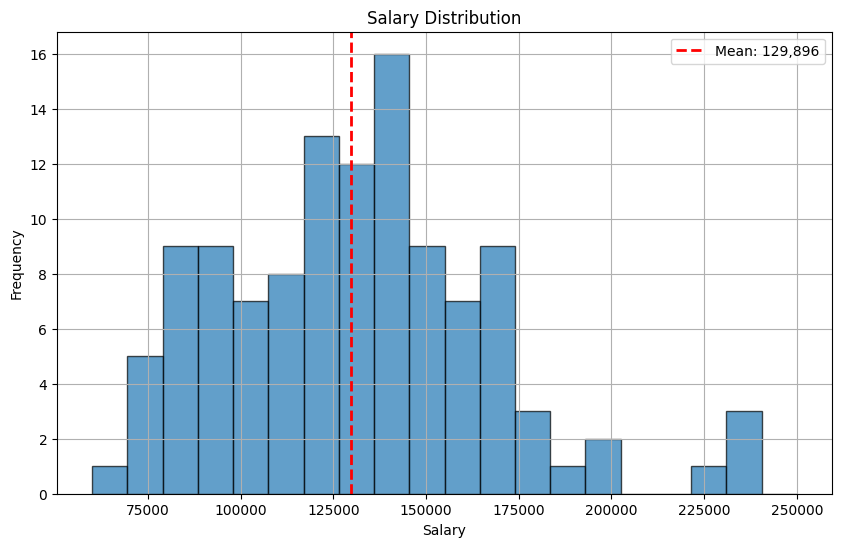

In [21]:
# 60 - 250
salary_df['salary'].hist(bins = 20, range=(60000,250000), edgecolor='black', alpha=0.7, figsize=(10, 6))
avg_salary = salary_df['salary'].mean()

plt.axvline(avg_salary, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_salary:,.0f}')

plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.title("Salary Distribution")

plt.legend(loc='upper right')

plt.show()

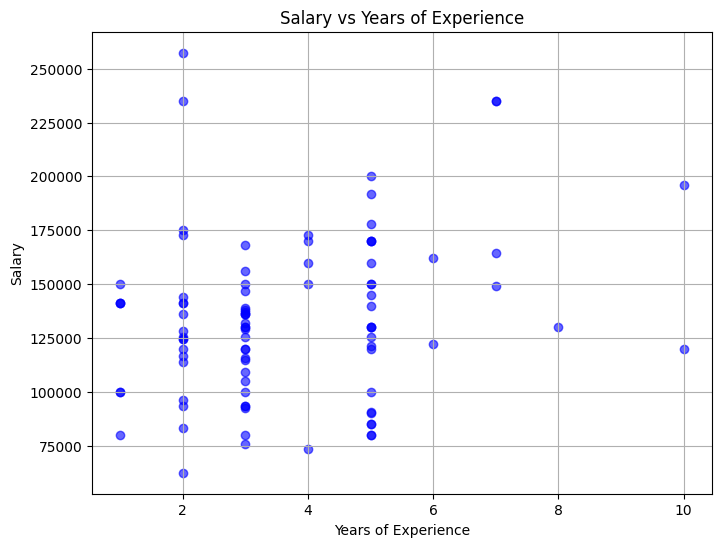

In [32]:
salary_yoe_df = jobs_df[(jobs_df['yoe'] != 0) & (jobs_df['salary'] != 0)].reset_index(drop=True)
salary_yoe_df.head(10)

plt.figure(figsize=(8, 6))
plt.scatter(salary_yoe_df['yoe'], salary_yoe_df['salary'], color='blue', alpha=0.6)
plt.title('Salary vs Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.grid(True)
plt.show()